 # Claim Analysis and Visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from matplotlib.patheffects import withStroke

# Set style parameters
plt.style.use('seaborn-v0_8-white')
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Define colors for assessment categories
ASSESSMENT_COLORS = {
    'Challenged': '#e74c3c',    # Red
    'Mixed': '#f39c12',         # Orange (changed from gray)
    'Unchallenged': '#95a5a6',  # Gray (changed from blue)
    'Partially Verified': '#f1c40f',  # Yellow
    'Verified': '#2ecc71'       # Green
}

EXPANDED_ASSESSMENT_COLORS = {
    'Challenged': '#e74c3c',                                # Main red
    'Challenged by reproducibility project': '#c0392b',     # Darker red
    'Challenged in literature': '#e74c3c',                  # Standard red
    
    'Mixed': '#f39c12',                                     # Orange
    
    'Unchallenged': '#95a5a6',                              # Main gray
    'Unchallenged, logically consistent': '#bdc3c7',        # Light gray
    'Unchallenged, logically inconsistent': '#7f8c8d',      # Dark gray
    'General unchallenged': '#95a5a6',                      # Medium gray
    
    'Partially Verified': '#f1c40f',                        # Yellow
    'Verified': '#2ecc71'                                   # Green
}


# Define the assessment category order for consistent plotting (reversed)
ASSESSMENT_ORDER = ['Challenged', 'Mixed', 'Unchallenged', 'Partially Verified', 'Verified']

# Define detailed mapping for Sankey diagram
DETAILED_MAPPING = {
    'Verified': {
        'Verified by literature': ['Verified'],
        'Verified by reproducibility': ['Verified by reproducibility pr...'],
        'Verified by authors': ['Verified by same authors']
    },
    'Challenged': {
        'Challenged (general)': ['Challenged'],
        'Challenged by reproducibility': ['Challenged by reproducibility ...'],
        'Challenged by authors': ['Challenged by same authors']
    },
    'Unchallenged': {
        'Logically consistent': ['Unchallenged, logically consis...'],
        'Logically inconsistent': ['Unchallenged, logically incons...'],
        'General unchallenged': ['Unchallenged']
    }
}

def categorize_journal(impact_factor):
    """Categorize journals based on impact factor."""
    if pd.isna(impact_factor):
        return None
    if impact_factor >= 30:
        return 'Trophy Journals'
    elif impact_factor >= 10:
        return 'High Impact'
    else:
        return 'Low Impact'

def group_assessment(assessment):
    """Group assessment types into broader categories."""
    if pd.isna(assessment) or assessment == 'Not assessed':
        return None
    if 'Verified' in str(assessment):
        return 'Verified'
    elif 'Challenged' in str(assessment):
        return 'Challenged'
    elif 'Mixed' in str(assessment):
        return 'Mixed'
    elif 'Partially verified' in str(assessment):
        return 'Partially Verified'
    elif 'Unchallenged' in str(assessment):
        return 'Unchallenged'
    else:
        return None

def bin_years(year):
    """Bin years into predefined time periods."""
    if pd.isna(year):
        return None
    if year <= 1991:
        return '≤1991'
    elif year <= 1996:
        return '1992-1996'
    elif year <= 2001:
        return '1997-2001'
    elif year <= 2006:
        return '2002-2006'
    else:
        return '2007-2011'

def hex_to_rgba(hex_color, alpha=0.5):
    """Convert hex color to rgba with alpha."""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

def adjust_color(hex_color, factor=0.8):
    """Lighten or darken a hex color by a factor."""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    
    # Lighten the color
    r = min(255, int(r + (255 - r) * (1 - factor)))
    g = min(255, int(g + (255 - g) * (1 - factor)))
    b = min(255, int(b + (255 - b) * (1 - factor)))
    
    return f'#{r:02x}{g:02x}{b:02x}'



In [2]:
# Load data
df = pd.read_csv('preprocessed_data/claims_truncated_for_llm.csv')
df["assessment_type"].unique()


array([nan, 'Not assessed', 'Verified', 'Mixed', 'Unchallenged',
       'Unchallenged, logically consistent', 'Partially verified',
       'Challenged', 'Unchallenged, logically inconsistent',
       'Challenged by reproducibility project',
       'Challenged by same authors', 'Verified by same authors',
       'Verified by reproducibility project', 'Reproduction in progress'],
      dtype=object)

In [3]:
df[["assertion_type"]].value_counts()


assertion_type    
assessment            6423
evidence              3886
major_claim           1006
minor_claim            590
main_claim             400
reference              399
method                 393
comment                148
additional_context      54
Name: count, dtype: int64

In [4]:
df[["assessment_type"]].value_counts()


assessment_type                      
Not assessed                             3791
Verified                                 2835
Unchallenged, logically consistent        668
Unchallenged                              622
Partially verified                        483
Challenged                                290
Verified by same authors                  141
Challenged by reproducibility project     139
Mixed                                     117
Unchallenged, logically inconsistent      116
Verified by reproducibility project        32
Challenged by same authors                 16
Reproduction in progress                   10
Name: count, dtype: int64

In [5]:
len(df)


13299

In [6]:
major_claims_df = df[df['assertion_type'] == 'major_claim']
print(len(major_claims_df))
major_claims_df


1006


,content,article_id,rank,pmid,authors_txt,title,pmid_article,volume,issue,abstract,...,large_scale,nber_tables,nber_panels,journal_name,impact_factor,assertion_type,label,is_assessed,assessment_type,rank_assessment_type
8,#gene:FBgn0000279 is...,3103.0,2,NaN,Tryselius Y;Samakovl...,"CecC, a cecropin gen...",1740152.0,204,1,Cecropins are antiba...,...,False,0.0,10.0,European journal of ...,5.4,major_claim,Major claim,True,Verified,1.0
30,Hemocyte proliferati...,2204.0,3,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,False,2.0,9.0,Proceedings of the N...,11.1,major_claim,Major claim,True,Verified,1.0
31,The Ras/MAPK pathway...,2204.0,1,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,False,2.0,9.0,Proceedings of the N...,11.1,major_claim,Major claim,True,Verified,1.0
37,The JAK/STAT and JNK...,2204.0,2,NaN,Zettervall CJ;Anderl...,A directed screen fo...,15381778.0,101,39,An attack by a paras...,...,False,2.0,9.0,Proceedings of the N...,11.1,major_claim,Major claim,True,Verified,1.0
110,#gene:FBgn0035976 fu...,2520.0,2,NaN,Gottar M;Gobert V;Mi...,The Drosophila immun...,11912488.0,416,6881,The antimicrobial de...,...,False,NaN,NaN,Nature,64.8,major_claim,Major claim,True,Verified,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13261,Ehrlichia chaffeensi...,1593.0,1,NaN,Luce-Fedrow A;Von Oh...,Ehrlichia chaffeensi...,19687202.0,77,11,Ehrlichia chaffeensi...,...,False,0.0,15.0,Infection and immuni...,3.1,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13264,B. bassiana inhibits...,1532.0,2,NaN,Matskevich AA;Quinti...,The Drosophila PRR G...,20201042.0,40,5,The Drosophila Toll-...,...,False,0.0,26.0,European journal of ...,5.4,major_claim,Major claim,True,"Unchallenged, logically consistent",6.0
13270,A polyclonal antibod...,3004.0,2,NaN,Georgel P;Kappler C;...,Drosophila immunity....,7537872.0,23,7,Bacterial challenge ...,...,False,1.0,10.0,Nucleic acids resear...,14.9,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0
13273,A pathway in additio...,2874.0,3,NaN,Wu LP;Anderson KV,Regulated nuclear im...,9510254.0,392,6671,The Drosophila immun...,...,False,0.0,16.0,Nature,64.8,major_claim,Major claim,True,"Unchallenged, logically inconsistent",7.0


In [7]:

# Apply categorizations
major_claims_df['journal_category'] = major_claims_df['impact_factor'].apply(categorize_journal)
major_claims_df['assessment_group'] = major_claims_df['assessment_type'].apply(group_assessment)


/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/1323218188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df['journal_category'] = major_claims_df['impact_factor'].apply(categorize_journal)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/1323218188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_claims_df['assessment_group'] = major_claims_df['assessment_type'].apply(group_assessment)


In [8]:
unique_pairs = major_claims_df[["journal_name", "impact_factor"]].drop_duplicates().sort_values("impact_factor", ascending=False)
for index, row in unique_pairs.iterrows():
    # Count occurrences of this journal in major_claims
    count = len(major_claims_df[major_claims_df["journal_name"] == row["journal_name"]])
    print(f"{row['impact_factor']:.1f}\t{row['journal_name']} ({count} claims)")


64.8	Nature (20 claims)
64.5	Cell (15 claims)
56.9	Science (New York, N... (27 claims)
32.4	Immunity (24 claims)
30.5	Nature immunology (28 claims)
30.3	Cell host & microbe (11 claims)
16.0	Molecular cell (8 claims)
14.9	Nucleic acids resear... (11 claims)
14.8	Nature protocols (1 claims)
11.8	Developmental cell (24 claims)
11.4	The EMBO journal (56 claims)
11.1	Proceedings of the N... (119 claims)
10.5	Genes & development (25 claims)
10.3	National Cancer Inst... (2 claims)
9.8	PLoS biology (19 claims)
9.3	Experientia (1 claims)
9.2	Current biology : CB (36 claims)
9.1	EMBO reports (31 claims)
7.8	The Journal of bioph... (2 claims)
7.8	The Journal of cell ... (1 claims)
7.8	Aging cell (6 claims)
7.0	Molecular & cellular... (3 claims)
6.9	Journal of experimen... (2 claims)
6.7	PLoS pathogens (40 claims)
5.8	Microbes and infecti... (7 claims)
5.6	Journal of molecular... (4 claims)
5.6	Journal of the Ameri... (3 claims)
5.4	The FEBS journal (3 claims)
5.4	European journal of ... (15 claim

In [9]:
major_claims_df[["journal_category", "journal_name"]][major_claims_df["journal_category"] == "Trophy Journals"]["journal_name"].value_counts()



journal_name
Nature immunology          28
Science (New York, N...    27
Immunity                   24
Nature                     20
Cell                       15
Cell host & microbe        11
Name: count, dtype: int64

 ## Constants and Helper Functions

 ## Plot Functions

In [10]:
def create_stacked_bar_plot(df, mode='absolute', by_time=False):
    """
    Create a stacked bar plot of major claims.
    
    Parameters:
    - df: DataFrame with claims data
    - mode: 'absolute' for counts or 'percentage' for percentages
    - by_time: If True, group by time periods; if False, group by journal categories
    
    Returns:
    - fig, ax: Matplotlib figure and axes objects
    """
    
    # Apply categorizations
    df['assessment_group'] = df['assessment_type'].apply(group_assessment)
    
    if by_time:
        # Group by time periods
        df['group_by'] = df['year'].apply(bin_years)
        group_order = ['≤1991', '1992-1996', '1997-2001', '2002-2006', '2007-2011']
        x_label = 'Time Period'
    else:
        # Group by journal categories
        df['group_by'] = df['impact_factor'].apply(categorize_journal)
        group_order = ['Low Impact', 'High Impact', 'Trophy Journals']
        x_label = 'Journal Category'
    
    # Create pivot table
    pivot_data = pd.pivot_table(
        df[df['group_by'].notna() & df['assessment_group'].notna()],
        values='num',
        index='group_by',
        columns='assessment_group',
        aggfunc='count',
        fill_value=0
    )
    
    # Reorder index
    pivot_data = pivot_data.reindex(index=group_order)
    
    # Calculate percentages
    pivot_pct = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Choose data based on mode
    plot_data = pivot_data if mode == 'absolute' else pivot_pct
    
    # Plot stacked bars
    bottom = np.zeros(len(plot_data))
    for col in reversed(ASSESSMENT_ORDER):
        if col in plot_data.columns:
            ax.bar(plot_data.index, plot_data[col], bottom=bottom, label=col, color=ASSESSMENT_COLORS[col])
            
            # Add labels
            for i in range(len(plot_data.index)):
                if plot_data[col][i] > 0:
                    # Format label based on mode
                    if mode == 'absolute':
                        label_text = f'{int(plot_data[col][i])} ({pivot_pct[col][i]:.1f}%)'
                    else:
                        # Only show labels for segments > 5% in percentage mode
                        if pivot_pct[col][i] <= 5:
                            continue
                        label_text = f'{pivot_pct[col][i]:.1f}%'
                    
                    text = ax.text(i, bottom[i] + plot_data[col][i]/2,
                                 label_text,
                                 ha='center', va='center',
                                 color='white', fontweight='bold')
                    text.set_path_effects([withStroke(linewidth=3, foreground='black')])
            
            bottom += plot_data[col]
    
    # Customize the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Customize grid
    ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
    ax.set_axisbelow(True)
    
    # Set titles and labels
    if mode == 'absolute':
        y_label = 'Number of Claims'
        title_prefix = ''
    else:
        y_label = 'Percentage of Claims'
        title_prefix = 'Distribution of '
    
    if by_time:
        title = f'{title_prefix}Major Claims by Time Period and Assessment Type'
    else:
        title = f'{title_prefix}Major Claims by Journal Category and Assessment Type'
    
    ax.set_title(title, pad=20)
    ax.set_xlabel(x_label, labelpad=10)
    ax.set_ylabel(y_label, labelpad=10)
    
    # Rotate x-axis labels if needed
    if by_time:
        plt.xticks(rotation=45)
    
    # Add legend
    legend = ax.legend(title='Assessment Type',
                      bbox_to_anchor=(1.02, 0.5),
                      loc='center left',
                      fontsize=SMALL_SIZE,
                      title_fontsize=MEDIUM_SIZE)
    legend.get_frame().set_linewidth(0.0)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

def create_sankey_diagram(df):
    """
    Create a Sankey diagram for claim assessment flow.
    
    Parameters:
    - df: DataFrame with claims data
    
    Returns:
    - fig: Plotly figure object
    """
    # Use global color scheme
    base_colors = ASSESSMENT_COLORS
    
    # Define blue color for the reproduction branch
    reproduction_color = '#3498db'  # Nice blue color
    
    # Use global detailed mapping but with updated labels
    detailed_mapping = {
        'Verified': {
            'Verified in literature': ['Verified'],
            'Verified by reproducibility project': ['Verified by reproducibility project'],
            'Verified by same authors': ['Verified by same authors']
        },
        'Challenged': {
            'Challenged in literature': ['Challenged'],
            'Challenged by reproducibility project': ['Challenged by reproducibility project'],
            'Challenged by same authors': ['Challenged by same authors']
        },
        'Unchallenged': {
            'Logically consistent': ['Unchallenged, logically consistent'],
            'Logically inconsistent': ['Unchallenged, logically inconsistent'],
            'General unchallenged': ['Unchallenged'],
            'Selected for manual reproduction': ['Verified by reproducibility project', 'Challenged by reproducibility project']
        }
    }
    
    # Node label mappings for display
    node_label_mappings = {
        'Selected for manual reproduction': 'Selected for manual reproduction',
        'Verified by reproducibility project': 'Verified',
        'Challenged by reproducibility project': 'Challenged'
    }
    
    # Count claims
    nodes = []
    node_labels = []
    source = []
    target = []
    value = []
    node_colors = []
    link_colors = []  # Initialize link_colors list here
    
    # Add root node
    total_claims = len(df)
    nodes.append('All Major Claims')
    node_labels.append(f'All Major Claims ({total_claims})')
    node_colors.append('#2c3e50')
    
    # Calculate counts for reproducibility project items
    verified_repro_count = len(df[df['assessment_type'] == 'Verified by reproducibility project'])
    challenged_repro_count = len(df[df['assessment_type'] == 'Challenged by reproducibility project'])
    repro_total = verified_repro_count + challenged_repro_count
    
    # First level: main categories with adjusted counts
    first_level_counts = {}
    for category in ['Verified', 'Challenged', 'Unchallenged', 'Mixed', 'Partially Verified', 'Not assessed', 'Reproduction in progress']:
        if category in detailed_mapping:
            # Count total for categories with subcategories
            total = 0
            
            # For Unchallenged, we need to include the reproducibility project items in the initial flow
            skip_types = []
            if category == 'Verified':
                skip_types = ['Verified by reproducibility project']
            elif category == 'Challenged':
                skip_types = ['Challenged by reproducibility project']
            
            for subcategory_name, subcategory_types in detailed_mapping[category].items():
                if subcategory_name != 'Selected for manual reproduction':  # Updated label
                    subcategory_types_filtered = [t for t in subcategory_types if t not in skip_types]
                    if subcategory_types_filtered:
                        mask = df['assessment_type'].isin(subcategory_types_filtered)
                        total += df[mask]['assessment_type'].count()
            
            # Include reproducibility project items in the initial flow to Unchallenged
            if category == 'Unchallenged':
                total += repro_total  # Add repro items to the initial unchallenged count
            
            if total > 0:
                first_level_counts[category] = total
                nodes.append(category)
                # Add percentage to first level node labels
                percentage = (total / total_claims) * 100
                node_labels.append(f'{category} ({total}, {percentage:.1f}%)')
                source.append(0)
                target.append(len(nodes) - 1)
                value.append(total)
                node_colors.append(base_colors.get(category, '#95a5a6'))
        else:
            # Direct count for categories without subcategories
            if category == 'Partially Verified':
                mask = df['assessment_type'] == 'Partially verified'
            elif category == 'Mixed':
                mask = df['assessment_type'] == 'Mixed'
            elif category == 'Not assessed':
                mask = df['assessment_type'] == 'Not assessed'
            elif category == 'Reproduction in progress':
                mask = df['assessment_type'] == 'Reproduction in progress'
            else:
                continue
                
            count = df[mask]['assessment_type'].count()
            if count > 0:
                nodes.append(category)
                # Add percentage to first level node labels
                percentage = (count / total_claims) * 100
                node_labels.append(f'{category} ({count}, {percentage:.1f}%)')
                source.append(0)
                target.append(len(nodes) - 1)
                value.append(count)
                node_colors.append(base_colors.get(category, '#95a5a6'))
    
    # Second level: detailed categories
    for main_category, subcategories in detailed_mapping.items():
        main_idx = nodes.index(main_category) if main_category in nodes else None
        if main_idx is not None:
            base_color = base_colors.get(main_category, '#95a5a6')
            for subcategory_name, assessment_types in subcategories.items():
                # Skip reproducibility project items for Verified/Challenged
                # as they'll be routed through Unchallenged first
                if (main_category in ['Verified', 'Challenged'] and 
                    subcategory_name in ['Verified by reproducibility project', 'Challenged by reproducibility project']):
                    continue
                
                # Get count
                mask = df['assessment_type'].isin(assessment_types)
                count = df[mask]['assessment_type'].count()
                
                # For "Selected for manual reproduction", use the precalculated counts
                if subcategory_name == 'Selected for manual reproduction':
                    count = repro_total
                
                if count > 0:
                    nodes.append(subcategory_name)
                    # Use custom node label if available, otherwise use the original name with count
                    display_name = node_label_mappings.get(subcategory_name, subcategory_name)
                    node_labels.append(f'{display_name} ({count})')
                    source.append(main_idx)
                    target.append(len(nodes) - 1)
                    value.append(count)
                    
                    # Use blue for the reproduction subcategory
                    if subcategory_name == 'Selected for manual reproduction':
                        node_colors.append(reproduction_color)
                        link_colors.append(hex_to_rgba(reproduction_color))
                    else:
                        # Use lighter version of the base color for subcategories
                        node_colors.append(adjust_color(base_color, 0.85))
                        link_colors.append(hex_to_rgba(adjust_color(base_color, 0.85)))
    
    # Create initial link colors for other nodes
    # We need to skip the links we've already colored (for the reproduction pathway)
    link_count = len(source) - len(link_colors)
    for i in range(link_count):
        s = source[i]
        t = target[i]
        target_color = node_colors[t]
        link_colors.insert(i, hex_to_rgba(target_color))
    
    # Special case: Add flow from "Selected for manual reproduction" to direct endpoints
    if 'Unchallenged' in nodes and 'Selected for manual reproduction' in nodes:
        unchallenged_idx = nodes.index('Unchallenged')
        tested_idx = nodes.index('Selected for manual reproduction')
        
        if verified_repro_count > 0:
            # Add a node for "Verified" as a direct endpoint
            nodes.append('Verified by reproducibility project')
            display_name = node_label_mappings.get('Verified by reproducibility project', 'Verified by reproducibility project')
            node_labels.append(f'{display_name} ({verified_repro_count})')
            node_colors.append(ASSESSMENT_COLORS['Verified'])  # Use verified color
            
            # Add link from tested to verified - use blue to green gradient
            source.append(tested_idx)
            target.append(len(nodes) - 1)
            value.append(verified_repro_count)
            # Create a blend from blue to green for this link
            link_colors.append(hex_to_rgba(ASSESSMENT_COLORS['Verified']))
        
        if challenged_repro_count > 0:
            # Add a node for "Challenged" as a direct endpoint
            nodes.append('Challenged by reproducibility project')
            display_name = node_label_mappings.get('Challenged by reproducibility project', 'Challenged by reproducibility project')
            node_labels.append(f'{display_name} ({challenged_repro_count})')
            node_colors.append(ASSESSMENT_COLORS['Challenged'])  # Use challenged color
            
            # Add link from tested to challenged - use blue to red gradient
            source.append(tested_idx)
            target.append(len(nodes) - 1)
            value.append(challenged_repro_count)
            # Create a blend from blue to red for this link
            link_colors.append(hex_to_rgba(ASSESSMENT_COLORS['Challenged']))
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = node_labels,
            color = node_colors
        ),
        link = dict(
            source = source,
            target = target,
            value = value,
            color = link_colors
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text="Claims Assessment Flow",
        title_font_size=20,
        font_size=14,
        height=800,
        width=1200,
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    return fig

 ## Analysis and Visualization

 ### Journal Category Analysis

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/2639871446.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assessment_group'] = df['assessment_type'].apply(group_assessment)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/2639871446.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group_by'] = df['impact_factor'].apply(categorize_journal)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/2639871446.py:15: SettingWithCopyWarning: 
A value is t

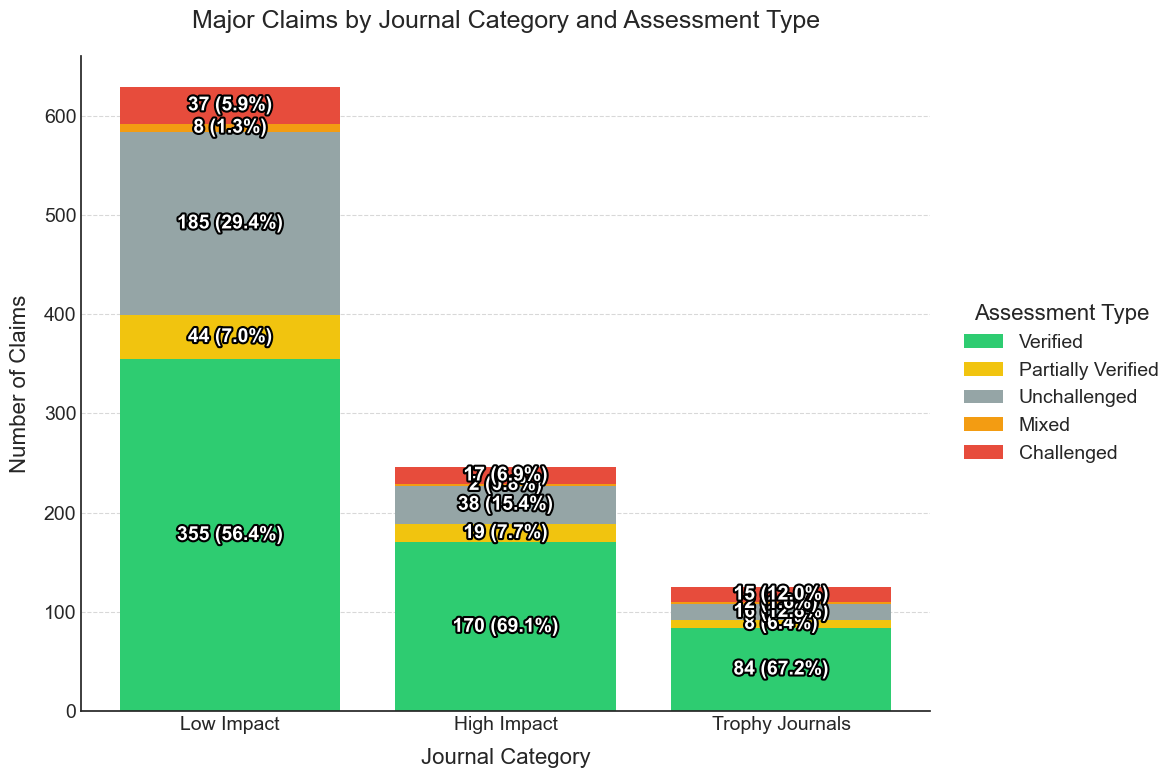

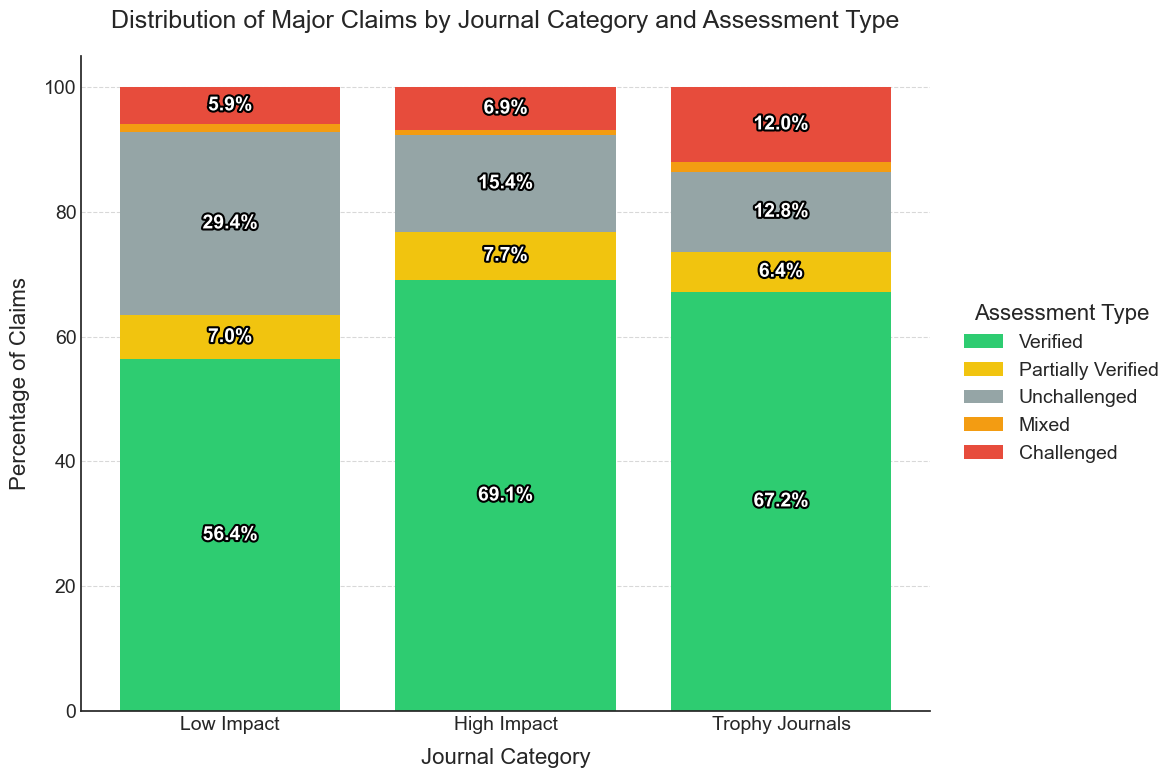

In [11]:
# Generate and save journal category plots
fig1, ax1 = create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=False)
plt.savefig('figures/claims_journal_absolute.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/claims_journal_absolute.pdf', bbox_inches='tight')

fig2, ax2 = create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=False)
plt.savefig('figures/claims_journal_percentage.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/claims_journal_percentage.pdf', bbox_inches='tight')


 ### Time Period Analysis

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/2639871446.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assessment_group'] = df['assessment_type'].apply(group_assessment)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/2639871446.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group_by'] = df['year'].apply(bin_years)
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_45048/2639871446.py:15: SettingWithCopyWarning: 
A value is trying to be set on

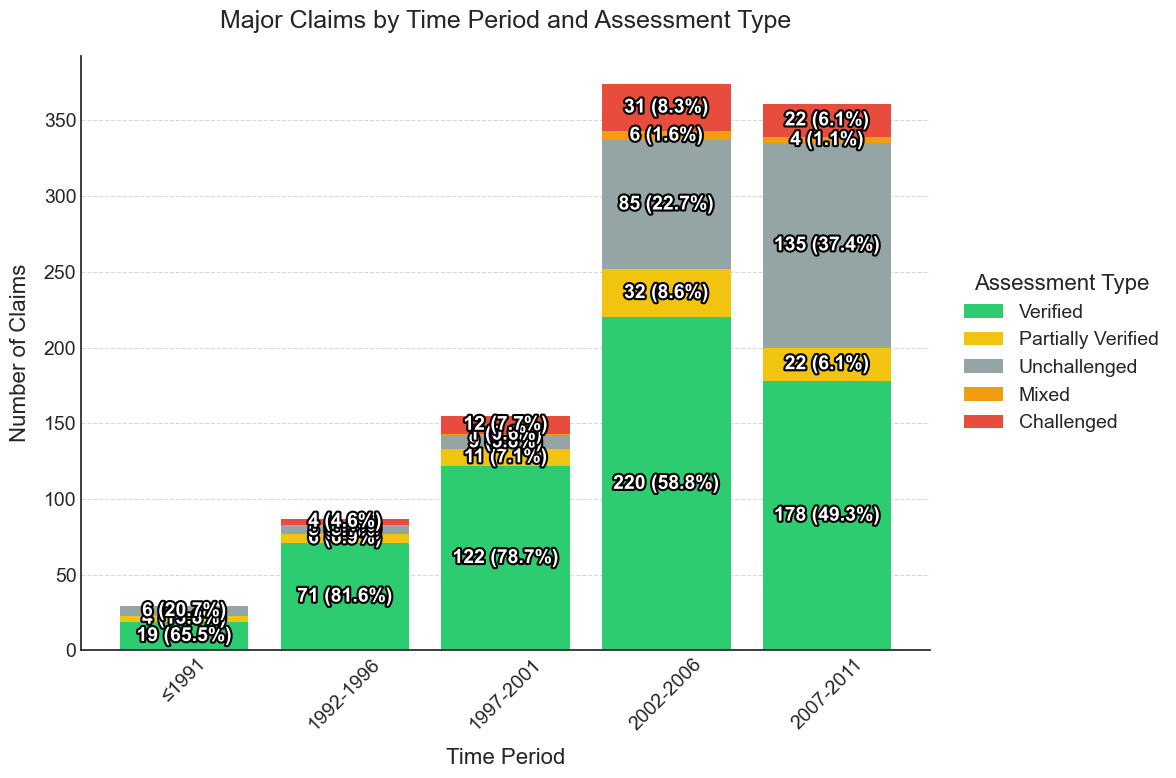

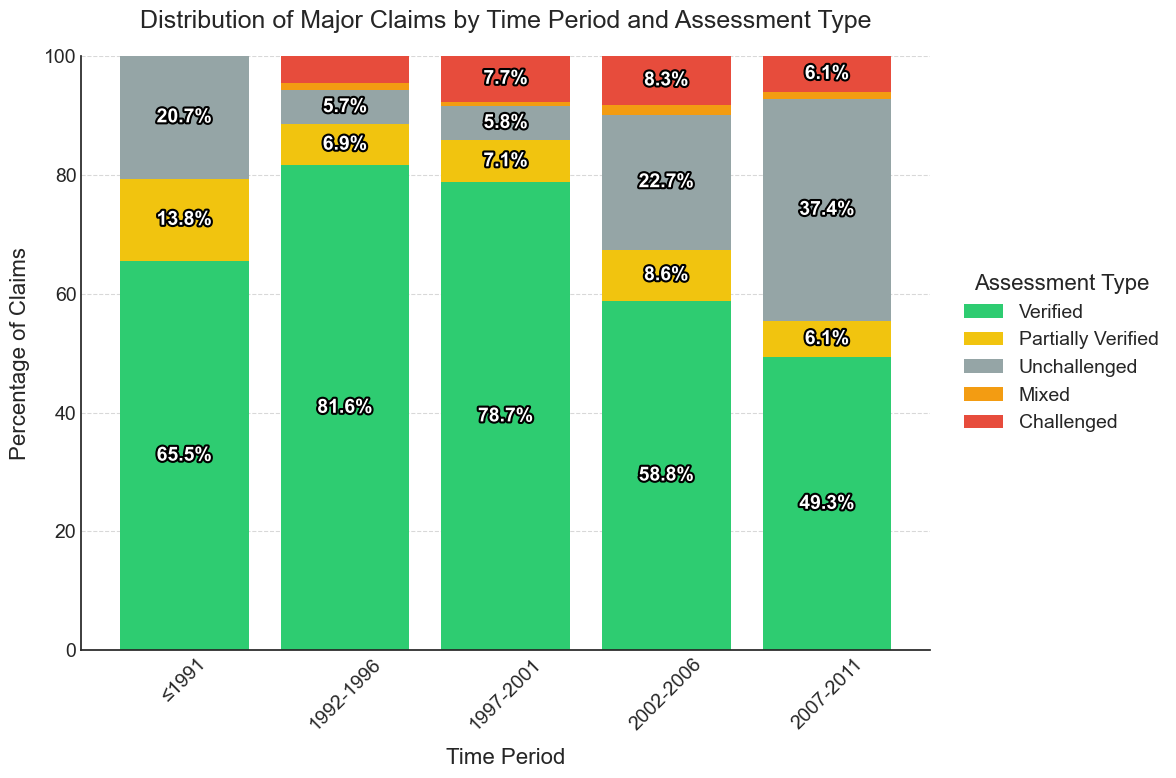

In [12]:
# Generate and save time period plots
fig3, ax3 = create_stacked_bar_plot(major_claims_df, mode='absolute', by_time=True)
plt.savefig('figures/claims_time_absolute.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/claims_time_absolute.pdf', bbox_inches='tight')

fig4, ax4 = create_stacked_bar_plot(major_claims_df, mode='percentage', by_time=True)
plt.savefig('figures/claims_time_percentage.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/claims_time_percentage.pdf', bbox_inches='tight')


 ### Trophy Journals Analysis

 ## Sankey Diagram

In [13]:
# Create Sankey diagram
to_plot = major_claims_df[["assertion_type", "label", "assessment_type", "rank_assessment_type"]]
fig = create_sankey_diagram(to_plot)
fig.show()
fig.write_html('figures/claims_sankey.html')
